In [1]:
import collections
import math
import os
import random
import zipfile
import numpy as np
import urllib
import tensorflow as tf

In [2]:
url='http://mattmahoney.net/dc/'
def maybe_download(filename,expected_bytes):
    if not os.path.exists(filename):
        filename,_=urllib.request.urlretrieve(url+filename,filename)
    statinfo=os.stat(filename)
    if statinfo.st_size==expected_bytes:
        print ('Found and verfied',filename)
    else:
        print (statinfo.st_size)
        raise Exception('Failed to verify'+filename+'. Can you get to it with a browser')
    return filename

In [3]:
filename=maybe_download('text8.zip',31344016)

Found and verfied text8.zip


In [4]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data=tf.compat.as_str(f.read(f.namelist()[0])).split(" ")
    return data
words=read_data(filename)
print ('Data size',len(words))

Data size 17005208


In [5]:
print (words[0:3])

['', 'anarchism', 'originated']


In [6]:
#创建vocabulary词汇表
vocabulary_size=50000

def build_dataset(words):
    count=[['UNK',-1]] 
    #most_common方法： 去top50000的频数的单词，创建一个dict,放进去。以词频排序
    counter=collections.Counter(words).most_common(vocabulary_size-1) #length of all counter:22159 取top1999频数的单词作为vocabulary，其他的作为unknown
    # print('123  :', type(count))  #list类型
    # print(len(counter)) #1999个
    print(counter[0:5])
    #[('the', 51897), ('and', 27525), ('to', 26996), ('he', 22203), ('of', 21851), ('a', 21043), ('harry', 18165), ('was', 15637), ('you', 14627), ('it', 14489),。 ('member', 49), ('fake', 49)。]
    count.extend(counter)
    #搭建dictionary
    dictionary={}
    for word,_ in count:
        dictionary[word]=len(dictionary)
    print('第一个单词the排名为   :',dictionary.get('the'))   #输出为1
    data=[]
    #全部单词转为编号
    #先判断这个单词是否出现在dictionary，如果是，就转成编号，如果不是，则转为编号0（代表UNK）
    unk_count=0
    for word in words:
        if word in dictionary:
            index=dictionary[word]
        else:
            index=0
            unk_count+=1
        data.append(index)

    count[0][1]=unk_count
    reverse_dictionary=dict(zip(dictionary.values(),dictionary.keys()))
    # print('aaaaa   ',data)                 #根据文章，将全文每个数，对应的排名标记， 比如 the 出现最多，则对应的数为1，不在前1999的标记为0  【959, 18, 7, 6, 1728, 0, 306, 13, 450, 1175, 32, 180, 265, 3, 9, 205,】
    # print('00000   ',count)               #前1999，个对应的出现的次数，第一个数是 总共多少不在前1999的字数   比如： the:51897
    # print('bbbbb   ',dictionary)          #前1999的数的dict  ['the':1]这种
    # print('1111   :',reverse_dictionary)  #按照dict值来排序，变得有规律起来。{0: 'UNK', 1: 'the', 2: 'and', 3: 'to', 4: 'he', 5: 'of', 6: 'a', 7: 'harry', 8: 'was', 9:}
    return data,count,dictionary,reverse_dictionary

In [7]:
data,count,dictionary,reverse_dictionary=build_dataset(words) 

[('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201)]
第一个单词the排名为   : 1


In [8]:
print(data[0:5])
print (count[0:5])

[0, 5238, 3082, 12, 6]
[['UNK', 418392], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]


In [9]:
print ('Sample data',data[:20],[reverse_dictionary[i] for i in data[:20]])

Sample data [0, 5238, 3082, 12, 6, 195, 2, 3134, 46, 59, 156, 128, 742, 477, 10577, 134, 1, 27722, 2, 1] ['UNK', 'anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the']


In [10]:
data_index=0

'''
采用Skip-Gram模式,  生成我们需要的 input label 的那种格式。，可以参看第二个小例子。
生成word2vec训练样本
@param batch_size:每个批次训练多少样本
@param num_skips: 为每个单词生成多少样本（本次实验是2个），batch_size必须是num_skips的整数倍,这样可以确保由一个目标词汇生成的样本在同一个批次中。
@param skip_window:单词最远可以联系的距离（本次实验设为1，即目标单词只能和相邻的两个单词生成样本），2*skip_window>=num_skips
'''
def generate_batch(batch_size,num_skips,skip_window):

    global data_index
    assert batch_size%num_skips==0
    assert num_skips<=2*skip_window

    batch=np.ndarray(shape=(batch_size),dtype=np.int32)
    # print(batch)  128个一维数组
    labels=np.ndarray(shape=(batch_size,1),dtype=np.int32)
    # print(labels)  128个二维数组
    span=2*skip_window+1   #入队长度
    # print(span)
    buffer=collections.deque(maxlen=span)
    
    for _ in range(span):  #双向队列填入初始值

        buffer.append(data[data_index])
        data_index=(data_index+1)%len(data)  
    # print('cishu :000', batch_size//num_skips)
    for i in range(batch_size//num_skips):  #第一次循环，i表示第几次入双向队列deque
        for j in range(span):  #内部循环，处理deque
            if j>skip_window:
                batch[i*num_skips+j-1]=buffer[skip_window]
                labels[i*num_skips+j-1,0]=buffer[j]
            elif j==skip_window:
                continue
            else:
                batch[i*num_skips+j]=buffer[skip_window]
                labels[i*num_skips+j,0]=buffer[j]
        buffer.append(data[data_index])  #入队一个单词，出队一个单词
        data_index=(data_index+1)%len(data)
    # print('batch    :',batch)
    # print('label    :',labels)
    return batch,labels    


In [11]:
batch,labels=generate_batch(batch_size=8,num_skips=2,skip_window=1)
for i in range(8):
    print (batch[i],reverse_dictionary[batch[i]],'->',labels[i,0],reverse_dictionary[labels[i,0]])

5238 anarchism -> 0 UNK
5238 anarchism -> 3082 originated
3082 originated -> 5238 anarchism
3082 originated -> 12 as
12 as -> 3082 originated
12 as -> 6 a
6 a -> 12 as
6 a -> 195 term


In [12]:
print (labels.shape)

(8, 1)


In [13]:
#开始训练
batch_size=128   
embedding_size=128
skip_window=1
num_skips=2
num_sampled=64  #训练时用来做负样本的噪声单词的数量
#验证数据
valid_size=16 #抽取的验证单词数
valid_window=100 #验证单词只从频数最高的100个单词中抽取
valid_examples=np.random.choice(valid_window,valid_size,replace=False)#不重复在0——10l里取16个


In [14]:
graph=tf.Graph()
with graph.as_default():
    train_inputs=tf.placeholder(tf.int32, shape=[batch_size])
    train_labels=tf.placeholder(tf.int32, shape=[batch_size,1])
    valid_dataset=tf.constant(valid_examples,dtype=tf.int32)
    #单词维度为 50000单词大小，128向量维度
    embeddings=tf.Variable(tf.random_uniform([vocabulary_size,embedding_size], -1.0, 1.0))   #初始化embedding vector
    #使用tf.nn.embedding_lookup查找输入train_inputs 对应的向量embed
    embed=tf.nn.embedding_lookup(embeddings, train_inputs) 
    
    #用NCE loss作为优化训练的目标
    #tf.truncated_normal初始化nce loss中的权重参数 nce_weights,并将nce_biases初始化为0
    nce_weights=tf.Variable(tf.truncated_normal([vocabulary_size,embedding_size], stddev=1.0/np.math.sqrt(embedding_size)))
    nce_bias=tf.Variable(tf.zeros([vocabulary_size]))
    #计算学习出的词向量embedding在训练数据上的loss,并使用tf.reduce_mean进行魂汇总
    loss=tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_bias, train_labels, embed, num_sampled, num_classes=vocabulary_size))
    #学习率为1.0，L2范式标准化后的enormalized_embedding。
    #通过cos方式来测试  两个之间的相似性，与向量的长度没有关系。
    optimizer=tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    norm=tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
    normalized_embeddings=embeddings/norm   #除以其L2范数后得到标准化后的normalized_embeddings
    
    valid_embeddings=tf.nn.embedding_lookup(normalized_embeddings,valid_dataset)    #如果输入的是64，那么对应的embedding是normalized_embeddings第64行的vector
    similarity=tf.matmul(valid_embeddings,normalized_embeddings,transpose_b=True)   #计算验证单词的嵌入向量与词汇表中所有单词的相似性
    print('相似性：',similarity)
    init=tf.global_variables_initializer()

相似性： Tensor("MatMul_1:0", shape=(16, 50000), dtype=float32)


In [15]:
num_steps=100001
with tf.Session(graph=graph) as session:
    init.run()
    print("Initialized")
    avg_loss=0
    for step in range(num_steps):
        batch_inputs,batch_labels=generate_batch(batch_size, num_skips, skip_window)  #产生批次训练样本
        feed_dict={train_inputs:batch_inputs,train_labels:batch_labels}   #赋值
        _,loss_val=session.run([optimizer,loss],feed_dict=feed_dict)
        avg_loss+=loss_val
        #每2000次，计算一下平均loss并显示出来。
        if step % 2000 ==0:
            if step>0:
                avg_loss/=2000
            print("Avg loss at step ",step,": ",avg_loss)
            avg_loss=0
            #每10000次，验证单词与全部单词的相似度，并将与每个验证单词最相似的8个找出来。
        if step%10000==0:
            sim=similarity.eval()
            for i in range(valid_size):
                valid_word=reverse_dictionary[valid_examples[i]]  #得到验证单词
                top_k=8  
                nearest=(-sim[i,:]).argsort()[1:top_k+1]     #每一个valid_example相似度最高的top-k个单词
                log_str="Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word=reverse_dictionary[nearest[k]]
                    log_str="%s %s," %(log_str,close_word)
                print(log_str)
    final_embedding=normalized_embeddings.eval()

Initialized
Avg loss at step  0 :  307.468139648
Nearest to so: overlord, scruggs, expounded, mizrahi, fingertips, anesthesia, quimby, factorials,
Nearest to many: goodnight, ecowas, sih, hurtful, jurists, turnovers, cjd, hauling,
Nearest to a: mussorgsky, halide, smoothing, hudsucker, qwerty, priscus, cts, amending,
Nearest to called: enya, dodecahedron, stomp, andrews, scipio, spaceflight, descending, commemorative,
Nearest to system: moselle, burning, bigelow, technique, replicated, wormwood, nonsense, swabia,
Nearest to four: calderas, buteo, unquestioned, lusignan, commemorate, abitibi, laughton, dutchman,
Nearest to to: live, feynman, viceroy, fullerene, heinrich, devalued, bold, pivots,
Nearest to as: mendelevium, biotic, placentia, suetonius, funimation, exacerbating, faculty, broadcasting,
Nearest to of: doth, fraud, diasporas, alistair, ampersand, dawkins, pie, twenty,
Nearest to world: decorations, schneier, bc, stray, beluga, endian, roadster, seperate,
Nearest to can: fari

In [17]:
print (sim.shape)

(16, 50000)


123213123
1231231


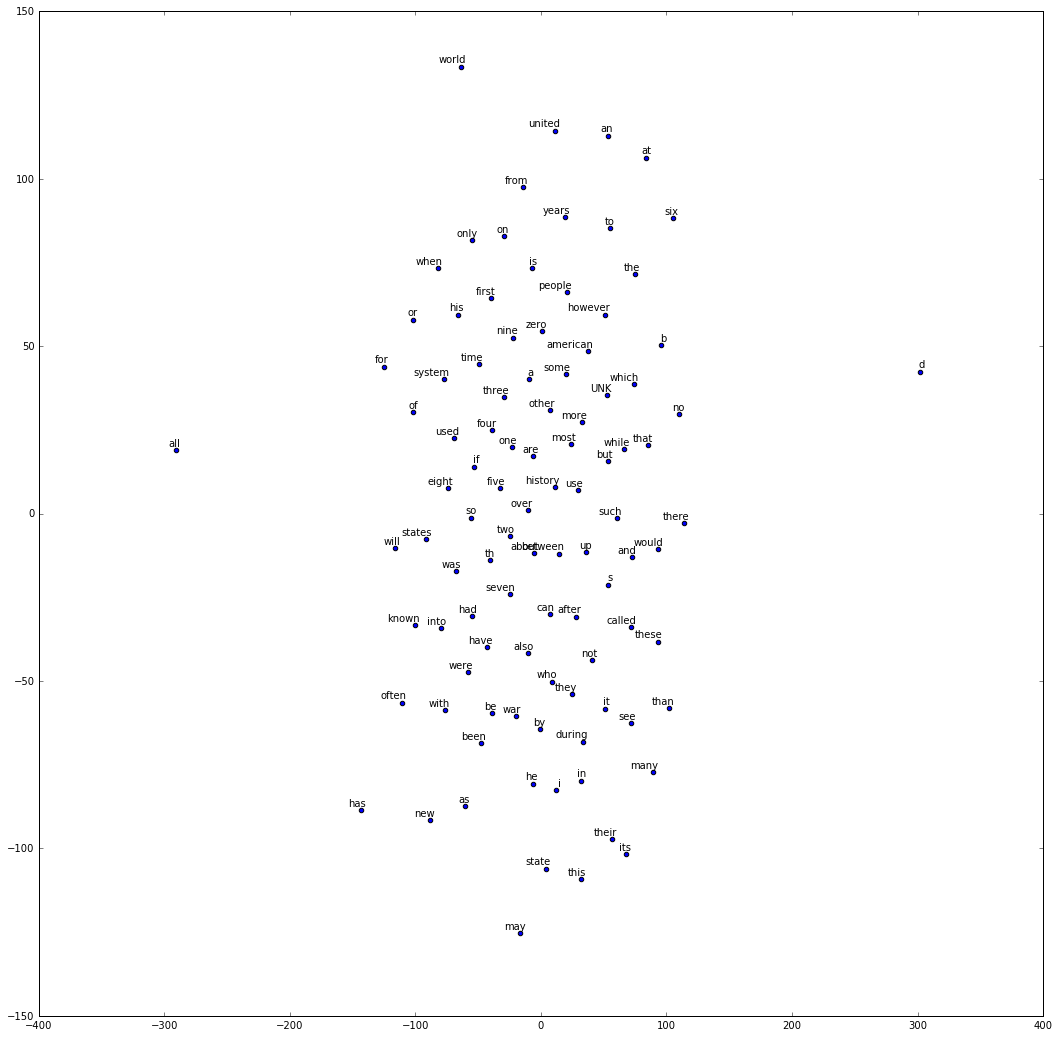

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
'''
可视化Word2Vec散点图并保存
'''
def plot_with_labels(low_dim_embs,labels,filename):
    #low_dim_embs 降维到2维的单词的空间向量
    assert low_dim_embs.shape[0]>=len(labels),"more labels than embedding"
    plt.figure(figsize=(18,18))
    for i,label in enumerate(labels):
        x,y=low_dim_embs[i,:]
        plt.scatter(x, y)
        #展示单词本身
        plt.annotate(label,xy=(x,y),xytext=(5,2),textcoords='offset points',ha='right',va='bottom')
    plt.savefig(filename)

'''
tsne实现降维，将原始的128维的嵌入向量降到2维
'''
print('123213123')
tsne=TSNE(perplexity=30,n_components=2,init='pca',n_iter=5000)
plot_number=100
low_dim_embs=tsne.fit_transform(final_embedding[:plot_number,:])
labels=[reverse_dictionary[i] for i in range(plot_number)]
plot_with_labels(low_dim_embs, labels, 'E:/machine_data/picture/plot.png')
print('1231231')

In [26]:
count=[['UNK',-1]]    #初始化单词频数统计集合
print (count)

[['UNK', -1]]


In [27]:
count.extend([(1,2),(2,3)])

In [28]:
count

[['UNK', -1], (1, 2), (2, 3)]

In [29]:
print (type(count[0]))
print (type(count[1]))

<class 'list'>
<class 'tuple'>


In [31]:
print (count[1][0])

1
